In [2]:
# Installing required libraries
!pip install yFinance statsmodels matplotlib pandas

In [3]:
# Importing important libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics. tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels. tsa.statespace.sarimax import SARIMAX
import warnings
warnings. filterwarnings('ignore' )

In [4]:
# Getting the data
gold_data = yf.download('GC=F', start='2005-01-01', end='2025-07-01',interval='1mo')
gold_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2005-01-01,421.799988,431.000000,418.700012,431.000000,115342
2005-02-01,436.500000,436.000000,410.100006,422.200012,8468
2005-03-01,428.700012,446.399994,424.700012,435.000000,3171
2005-04-01,435.000000,438.200012,422.700012,428.299988,2579
2005-06-01,435.899994,442.500000,414.000000,416.399994,6950


In [5]:
# Keep only closing price and remove missing values
gold= gold_data[['Close']].copy()
gold.columns=['Price']
gold.dropna(inplace=True)
gold.head()

,Price
Date,
2005-01-01,421.799988
2005-02-01,436.500000
2005-03-01,428.700012
2005-04-01,435.000000
2005-06-01,435.899994


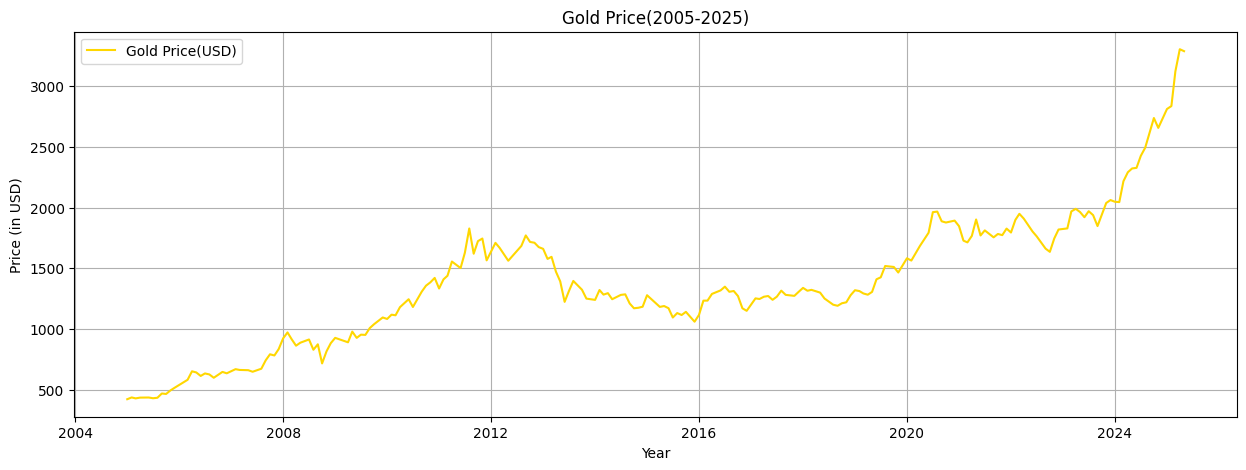

In [9]:
# Plot
plt.figure(figsize=(15,5))
plt.plot(gold, label='Gold Price(USD)', color='gold')
plt.title('Gold Price(2005-2025)')
plt.xlabel('Year')
plt.ylabel('Price (in USD)')
plt.grid(True)
plt.legend()
plt.show()


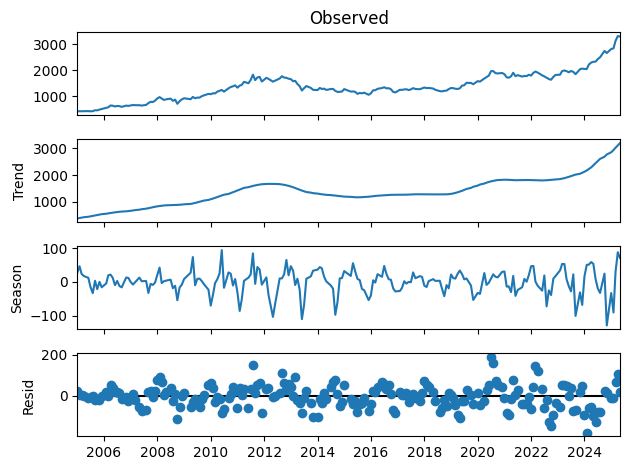

In [12]:
# STL Decomposition
stl = STL(gold, period=12)
res = stl.fit()
res.plot()
plt.show()




In [13]:
# ADF test for statioanrity
result = adfuller(gold['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('The series is stationary')
else:
    print('The series is non-stationary')

ADF Statistic: 1.535441
p-value: 0.997650
The series is non-stationary


Since, the data that we are working with is not stationary,
hence we cannot use AR, MA and ARMA models.

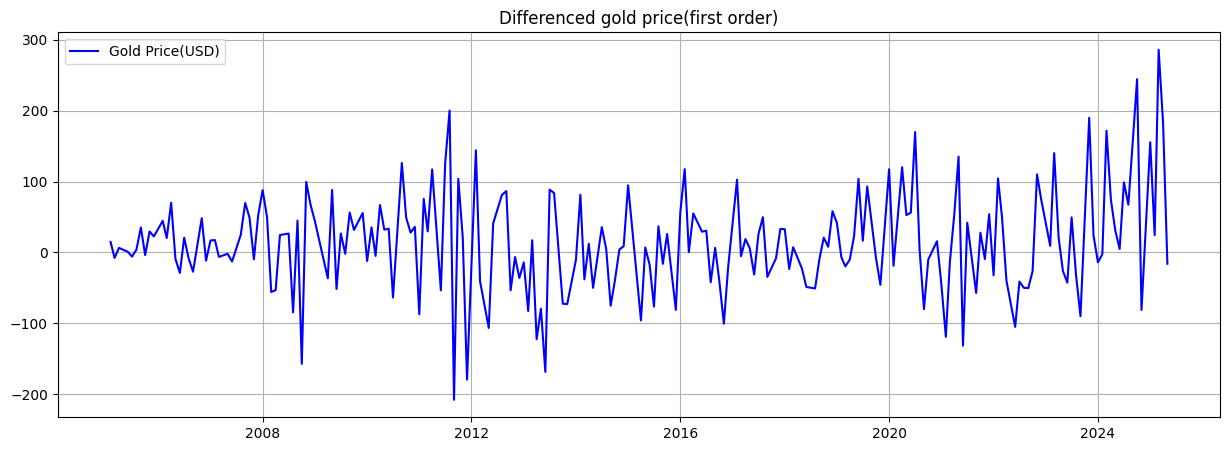

In [14]:
# Differencing to make series stationary
gold_diff = gold['Price'].diff().dropna()
plt.figure(figsize=(15,5))
plt.plot(gold_diff, label='Gold Price(USD)', color='blue')
plt.title('Differenced gold price(first order)')
plt.grid('True')
plt.legend()
plt.show()

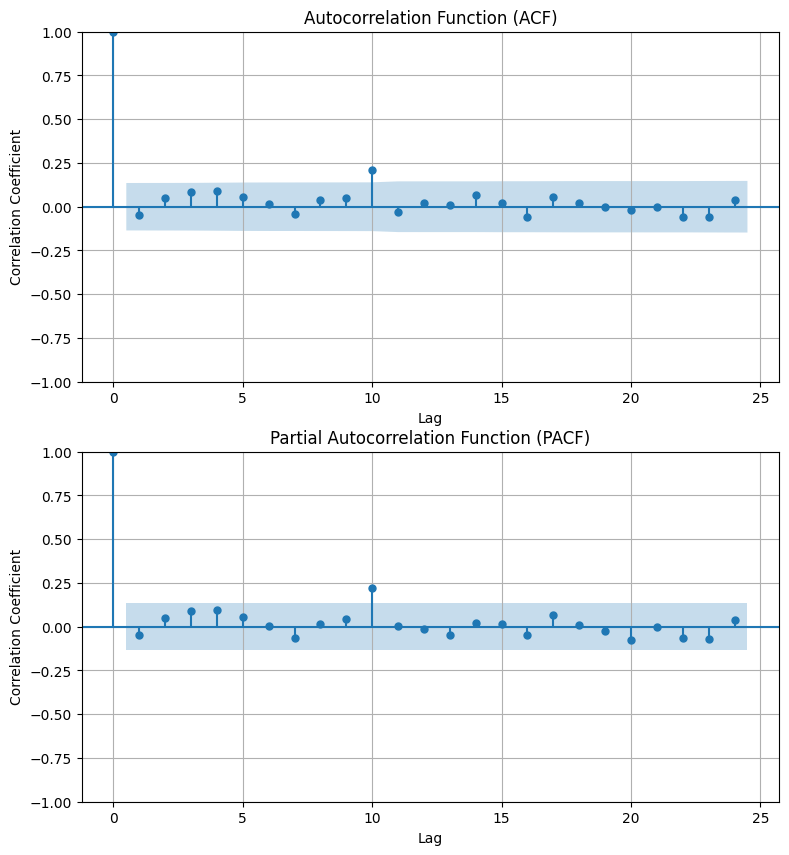

In [16]:
# ACF anf PACF Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (9, 10))

# ACF Plot
plot_acf(gold_diff, ax = ax1, lags = 24, alpha = 0.05)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_ylabel('Correlation Coefficient' )
ax1.set_xlabel('Lag')
ax1.grid(True)

# PACF Plot
plot_pacf(gold_diff, ax = ax2, lags = 24, alpha = 0.05)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_ylabel('Correlation Coefficient' )
ax2.set_xlabel('Lag')
ax2.grid(True)

# Significant spikes are seen in lag 10
# PACF cuts after lag p=1
# ACF cuts after lag q=1


acf shows how current gold prices are correlated with their past values. pacf  isolates the direct effect of past values on the current price, removing indirect correlations.

In [29]:
# Fitting the ARIMA model
model = ARIMA(gold['Price'] , order=(1, 1, 1))
model_fit_arima = model.fit()
print('\nArima Model Summary:\n')
print(model_fit_arima.summary())


Arima Model Summary:

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  210
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1192.363
Date:                Sun, 20 Jul 2025   AIC                           2390.727
Time:                        09:50:51   BIC                           2400.754
Sample:                             0   HQIC                          2394.781
                                - 210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9837      0.066    -14.858      0.000      -1.114      -0.854
ma.L1          0.9654      0.085     11.296      0.000       0.798       1.133
sigma2      5279.5055    428.

# Suggests strong negative autocorrelation in the lag-1 differenced series — the last change in price has a strong (but opposite) influence on the next change

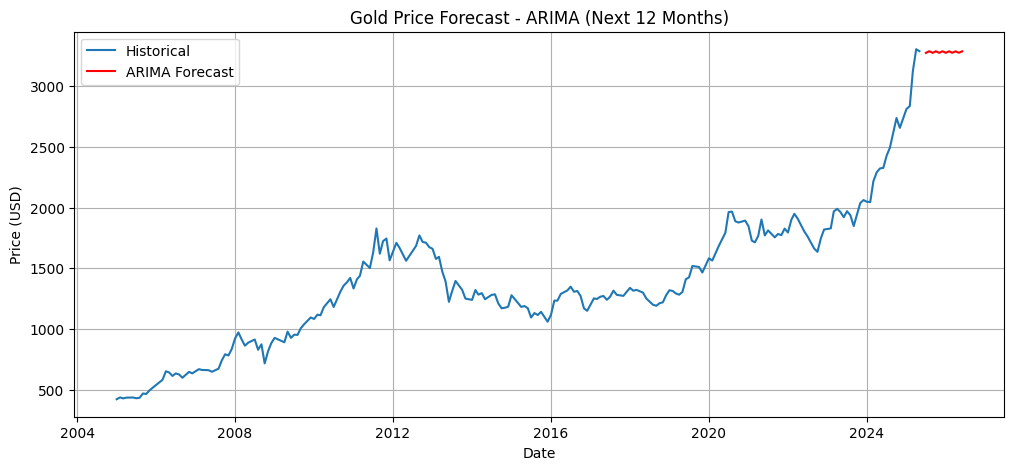

In [32]:
# Forecasting using ARIMA
forecast_arima= model_fit_arima.forecast(steps=12)
forecast_index=pd.date_range(start=gold.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
# Plot
plt.figure(figsize = (12, 5))
plt.plot(gold['Price'], label = 'Historical')
plt.plot(forecast_index, forecast_arima, label = 'ARIMA Forecast', color = 'red' )
plt.title('Gold Price Forecast - ARIMA (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# Forecasting using SARIMAX
model = SARIMAX(gold['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 10))
model_fit_sarima = model.fit()
print('\nSARIMA Model Summary:\n')
print(model_fit_sarima.summary())


SARIMA Model Summary:

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  210
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 10)   Log Likelihood               -1137.753
Date:                            Sun, 20 Jul 2025   AIC                           2285.507
Time:                                    09:51:09   BIC                           2301.973
Sample:                                         0   HQIC                          2292.171
                                            - 210                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1823      1.560     -0.117      0.907      -3.241       2.876
ma.L1      

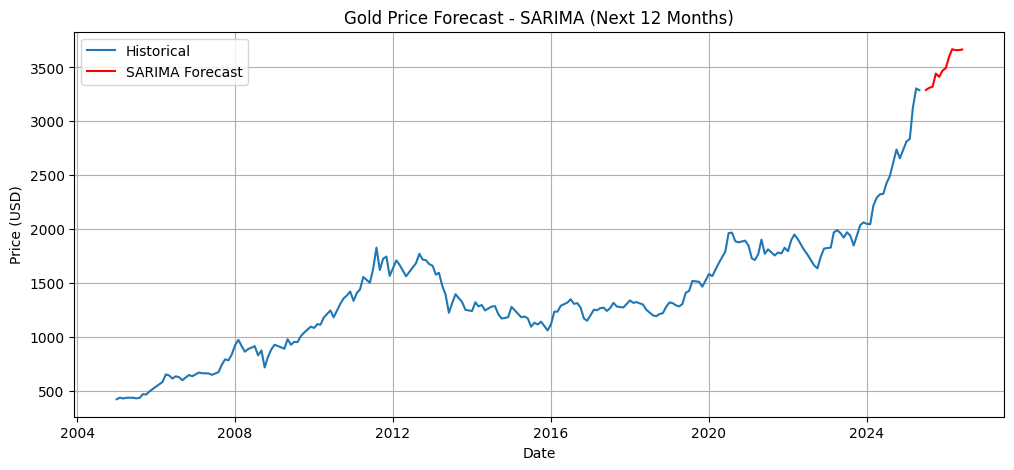

In [31]:
# Forecasting using SARIMA
forecast_sarima= model_fit_sarima.forecast(steps=12)
forecast_index=pd.date_range(start=gold.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
# Plot
plt.figure(figsize = (12, 5))
plt.plot(gold['Price'], label = 'Historical')
plt.plot(forecast_index, forecast_sarima, label = 'SARIMA Forecast', color = 'red' )
plt.title('Gold Price Forecast - SARIMA (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# We can see a increasing trend in SARIMA Forecasting

In [34]:
# Model Comparison
print("Model Comparison :")
print(f"ARIMA Model AIC: {model_fit_arima.aic}")
print(f"SARIMA Model AIC: {model_fit_sarima.aic}")

# Select model based on lesser AIC
if model_fit_arima.aic < model_fit_sarima.aic:
  print("\nARIMA model is selected.")
else:
  print("\nSARIMA model is selected.")

Model Comparison :
ARIMA Model AIC: 2390.726654760549
SARIMA Model AIC: 2285.5067238258735

SARIMA model is selected.


In [35]:
# Saving the SARIMA model in PICKLE file format
import pickle
pickle.dump(model_fit_sarima, open('sarima_gold_model.pkl', 'wb'))

In [ ]:
# Saving the ARIMA model in PICKLE file format
import pickle
pickle.dump(model_fit_arima, open('arima_gold_model.pkl', 'wb'))